In [1]:
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=f19e57a8bab5fcffa1640cad0d3d1fc681639d32637d786e0d08d0632ea3f1bd
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


Create a Synthetic Two-Class Dataset

Purpose: This cell defines a function clouds to generate a simple synthetic dataset with two distinct clusters (classes). This data is useful for testing and demonstrating classification algorithms like SVMs or QSVMs in a controlled environment.

Description: The function generates points for each class using numpy.random.multivariate_normal, centered around specified coordinates with given spreads. It assigns corresponding labels (-1 or 1) to these points.

Libraries Used: numpy (for data generation), matplotlib.pyplot (imported, typically used for visualization later).

Input/Output:

    Input: num_points (per class).
    Output: Lists x (data points) and y (labels).

Relevance to QML/SVM: Provides sample data for training/testing binary classification models.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def clouds(num_points=100):
  centers = [(1,1), (-1,-1)]
  spreads = [0.5, 0.7]
  labels = [-1, 1]

  x = []
  y = []
  for center, spread, label in zip(centers, spreads, labels):
    x += np.random.multivariate_normal(center, spread * np.identity(2), num_points).tolist()
    y += [label] * num_points

  return x, y

Visualize the Data

Purpose: This cell generates the dataset and shows it as a scatter plot to visualize the two classes.

What it does:

    Calls the clouds function to create data (x) and labels (y).
    Chooses colors for each class.
    Plots the points using these colors.

Uses: numpy and matplotlib.

Shows: The data the SVM/QSVM will work with.

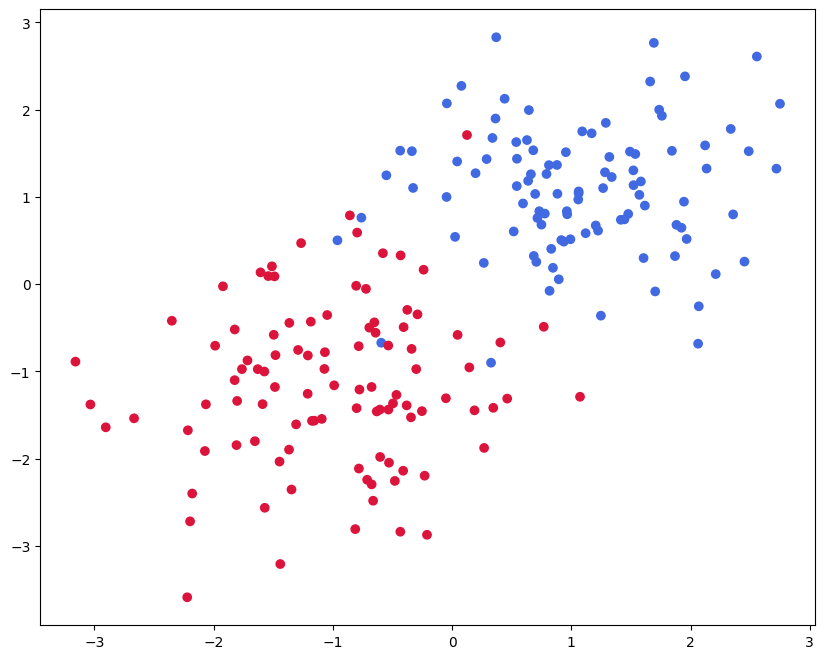

In [3]:
x, y = clouds(100)

colors = ["crimson" if label == 1 else "royalblue" for label in y]
plt.figure(figsize=(10,8))
plt.scatter(np.array(x)[:,0], np.array(x)[:,1], color=colors);

Define SVM Loss Function

Purpose: This cell defines the function used to calculate the "cost" or "error" of an SVM model given its parameters (weights and bias) and the training data. Minimizing this loss function is how the SVM model is typically trained.

What it does:


1.   Takes the SVM model's parameters (w and b) and the data (x, y).
2.   Calculates two main parts:
          The size (squared norm) of the weights w.
          A penalty term that is large if data points are on the wrong side of the margin or misclassified (using the hinge loss).
3.   Returns the sum of these two parts.

Uses: numpy.

Input: SVM model parameters (`support_vector`), data (`x, y`).

Output: A single number representing the total loss.

Relevance to SVM/QML: This is the core objective function ($||w||^2+C∑ξi$) that is minimized during the training of a standard C-Support Vector Classifier.

#Explanation of the SVM Objective Function Formula ($||w||^2+C∑ξi$)

This formula is the main goal (objective function) that a standard SVM tries to make as small as possible when learning from data.

It combines two things:


1.   $||w||^2$: This part is about the "width" of the separation line or plane (the margin). Making this value small means making the margin as wide as possible. A wider margin is often good for generalization.
2.   $C∑ξi$: This part is about the "errors" or "mistakes" on the training data. ξi​ (pronounced "ksi") measures how much a single data point is on the wrong side of the margin or even misclassified. It's the "violation" for point i. ∑ξi​ is the sum of these violations for all data points. It's the total error. C is a penalty number. A larger C means we care more about minimizing these errors, even if it means a narrower margin. A smaller C allows more errors for a wider margin.  

In short: The SVM tries to find the best separation line by minimizing this function, balancing having a wide margin ($||w||^2$ term) against making mistakes ($C∑ξi$​ term), with C controlling that balance.

In [4]:
# Defining the loss function

def loss(support_vector, x, y, penalty=1e5):
  w = support_vector[1:]
  b = support_vector[0]

  norm = np.linalg.norm(w) **2
  constraint = sum(max(0, 1 - y[i] * (np.dot(w, x[i]) - b)) for i in range(len(y)))

  return norm + penalty * constraint

#Train the SVM Model

Purpose: This cell trains the SVM model. It finds the best values for the model's parameters (weights w and bias b) that minimize the loss function we defined earlier, using the dataset (`x, y`).

What it does:

  * Imports an optimization tool from SciPy (minimize).
  * Runs the minimize function, telling it:
      *  Which function to minimize (our loss function).
      *   Where to start looking for the minimum (a random initial guess for the parameters).
      * Which method to use for the search (`L-BFGS-B`).
  *After the search finishes, it stores the found best parameters (w and b) in the variable `support_vector`.

Uses: `scipy.optimize, numpy`.

Input: The loss function and the data (`x, y`).

Output: The learned SVM parameters (`support_vector`).

Relevance to SVM/QML: This is the core step where the SVM algorithm actually learns the decision boundary from the data by minimizing its objective (loss) function.

In [5]:
from scipy.optimize import minimize

# Initialize the optimizer with L-BFGS-B method
result = minimize(
    lambda sv: loss(sv, x, y),  # The function to minimize
    x0=np.random.random(3),     # Initial guess
    method='L-BFGS-B',          # Specify the optimization method
    bounds=None                 # You can add bounds if needed, e.g. [(0, 1), (0, 1), (0, 1)]
)

support_vector = result.x

#Classify New Data

Purpose: This cell defines a function to predict the class of a single new data point using the SVM parameters (w and b) that we found during training.

What it does:

   *  Takes a new `point` and the trained `support_vector` (which holds `w` and `b`).
   * Uses the `w` and `b` values to calculate which side of the trained separation line the `point` falls on.
   *Returns the sign of this calculation (+1 or -1), which is the predicted class for the point.

Uses: `numpy`.

Input: A single data `point`, the trained SVM parameters (`support_vector`).

Output: The predicted class label (+1 or -1).

Relevance to SVM/QML: This is how the trained SVM model is used to make predictions on data it hasn't seen before.

In [6]:
# Classify our new points
def classify(point, support_vector):
  w = support_vector[1:]
  b = support_vector[0]
  return np.sign(np.dot(w, point) + b)

#Show Results and Boundary

Purpose: This cell visualizes how well the trained SVM classified the original data points and plots the separation line (decision boundary) that the SVM found.

What it does:

   *  Uses the `classify` function to predict the class for every point in the original dataset (`x`).
   * Plots each data point:
       * Its color shows its true original class.
       * The marker ('o' or 'x') shows if the SVM predicted its class correctly ('o') or incorrectly ('x').

* Calculates the coordinates for the SVM's separation line using the learned weights (`w`) and bias (`b`).
* Plots this separation line on top of the data points.

Uses: `numpy, matplotlib.pyplot`, and the `classify` function.

Input: The original data (`x, y`) and the trained SVM parameters (`support_vector`).

Output: A plot showing the data points with their classification results and the SVM's separation line.

Relevance to SVM/QML: Provides a visual way to evaluate the trained SVM's performance on the training data and to see the boundary it created to separate the classes

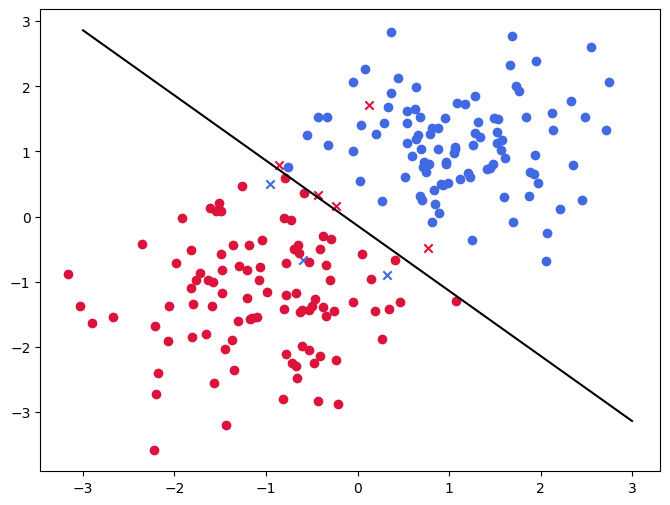

In [7]:
# Show Results and Boundary
predicted = [classify(point, support_vector) for point in x]
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(y, predicted)]
plt.figure(figsize=(8,6))
for point, marker, color in zip(x, markers, colors):
  plt.scatter(point[0], point[1], marker=marker, color=color)

b, w = support_vector[0], support_vector[1:]
x1 = np.linspace(-3,3, num=100)
x2 = -1 / w[1] * (w[1] * x1 + b)
plt.plot(x1, x2, "k-");

In [8]:
# You can just use the sklearn package
from sklearn.svm import SVC

model = SVC()
model.fit(x, y)

sk_predict = model.predict(x)

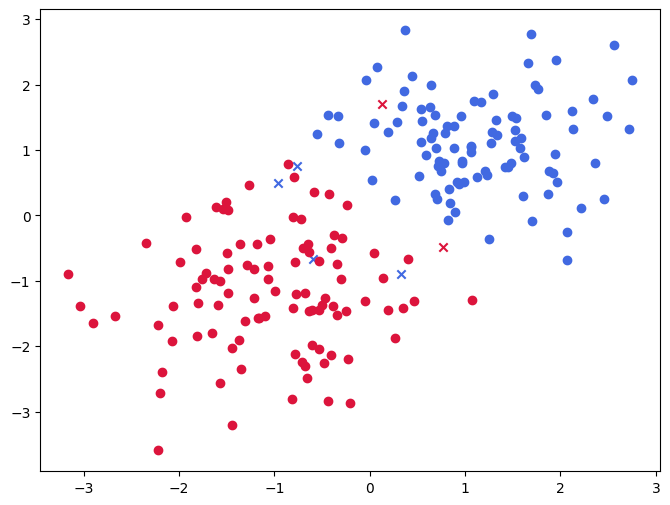

In [9]:
# Plot the results
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(y, sk_predict)]
plt.figure(figsize=(8,6))
for point, marker, color in zip(x, markers, colors):
  plt.scatter(point[0], point[1], marker=marker, color=color)

# Create Non-linear Data

Purpose: This cell defines a function to generate a synthetic dataset where the two classes are separated by a circle, making it a non-linear problem.

What it does:

  * Creates a set of random 2D points within a square region.
  * Assigns a label (+1 or -1) to each point based on whether it is located outside (+1) or inside (-1) a defined radius from the center.

Uses: `numpy`.

Input: None (generates a fixed number of points internally).

Output: A list of data `points` and a list of their corresponding `labels`.

Relevance to SVM/QML: This dataset is used to demonstrate problems that cannot be solved by a simple linear SVM and require non-linear techniques (like kernel methods or QSVMs).

In [10]:
# Non-linear data
def circle():
  num_points = 250
  points = 1 -2 * np.random.random((num_points, 2))

  radius = 0.6
  labels = [1 if np.linalg.norm(point) > radius else -1 for point in points]

  return points, labels

Text(0, 0.5, '')

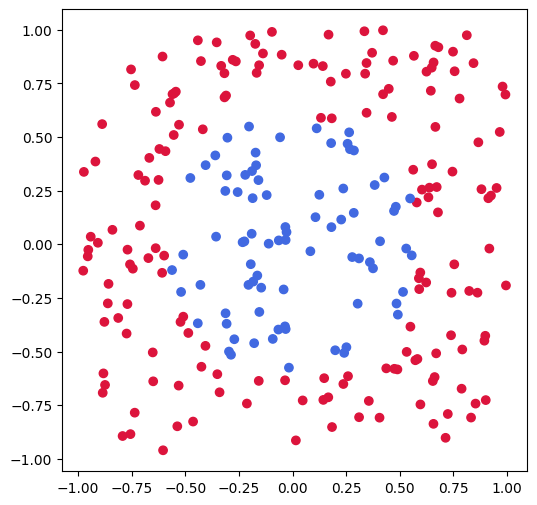

In [11]:
# Plot the results
points, labels = circle()
colors = ["crimson" if label == 1 else "royalblue" for label in labels]
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], color=colors)
plt.xlabel("")
plt.ylabel("")

#Data Feature Map

Purpose: This cell defines a function to transform each 2D data point into a 3D point using a specific formula. The idea is that data that is not linearly separable in 2D might become linearly separable in this new 3D space.

What it does:

  * Takes a 2D data point (like `[x, y]`).
  * Calculates a new value which is the sum of the squares of its coordinates (x2+y2).
  * Returns a new 3D point containing the original coordinates plus this new value (like `[x, y, x^2 + y^2]`).

Uses: `numpy`.

Input: A single 2D data point.

Output: A single 3D data point (as a NumPy array).

Relevance to SVM/QML: This is a simple example of a "feature map" or "embedding". This technique (related to the kernel trick in SVMs and quantum feature maps in QML) is used to handle non-linear data by mapping it into a higher dimension where a linear boundary might exist.

In [12]:
# Data Feature Map
# Embed data in higher dimensional space, maybe it's linearly separable there?
def feature_map(x):
  return np.array([x[0], x[1], x[0] ** 2 + x[1] ** 2])

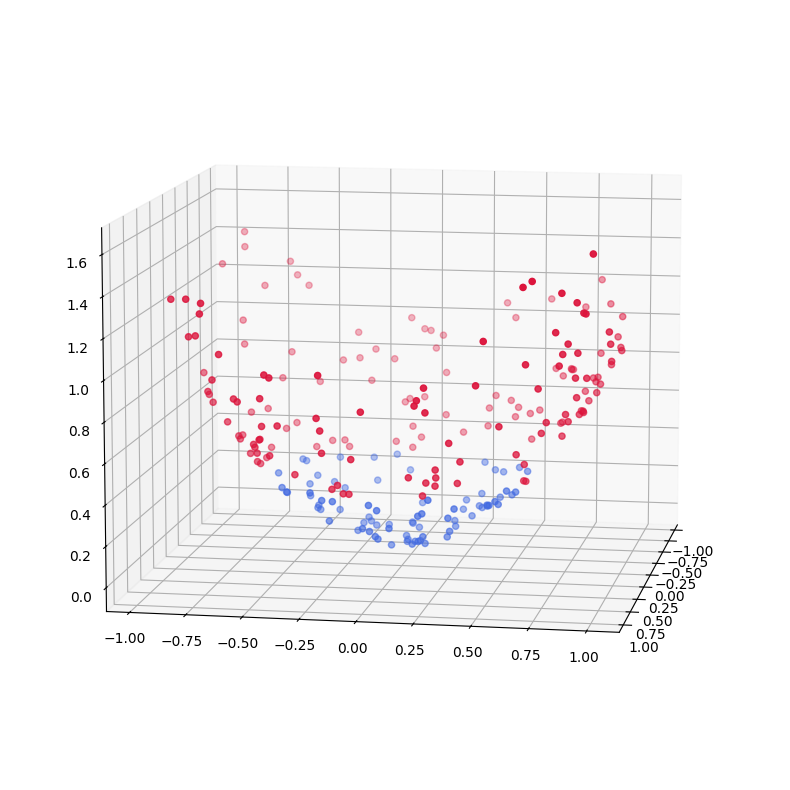

In [13]:
# Plot the new data
embedded_points = np.array([feature_map(point) for point in points])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedded_points[:, 0], embedded_points[:, 1], embedded_points[:, 2], color=colors)
ax.view_init(10, 10)

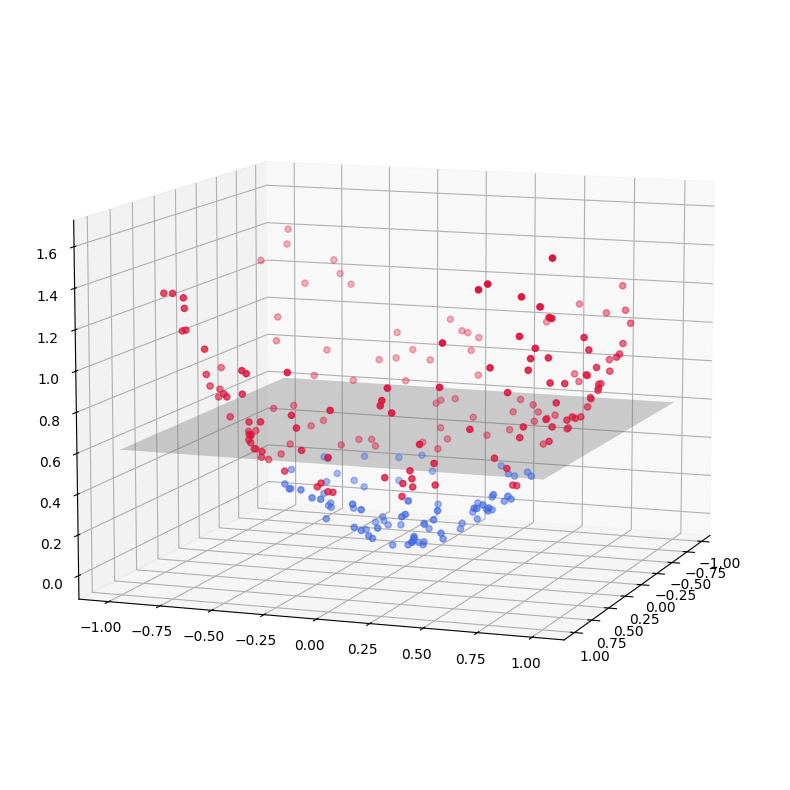

In [14]:
# Plot the new data with hyperplane
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedded_points[:, 0], embedded_points[:, 1], embedded_points[:, 2], color=colors)

x, y = np.meshgrid([1, -1], [1, -1])
ax.plot_surface(x, y, 0.6 * np.ones_like(x), alpha=0.3, color="grey")

ax.view_init(10, 20)

#Show Original Data and Circle Boundary

Purpose: This cell plots the data points again, but this time just showing their original 2D locations. It also draws the circle that was used to define the two classes in the first place.

What it does:

  * Takes the data points (even though they might be stored in a variable that held 3D points, it uses only the original 2D x and y coordinates).
  * Plots these 2D points, colored according to their original class.
  * Calculates points along a circle with the original boundary radius.
  * Plots this circle in grey to show the exact boundary used to separate the classes.

Uses: `numpy, matplotlib.pyplot`. Assumes `embedded_points` and `colors` variables exist.

Input: Data points (specifically their first two dimensions) and their class colors.

Output: A plot showing the 2D data distribution and the circular boundary.

Relevance to SVM/QML: This plot visually confirms that the original data is separated by a circle, highlighting why a simple linear SVM wouldn't work well in this original 2D space.

Text(0, 0.5, '')

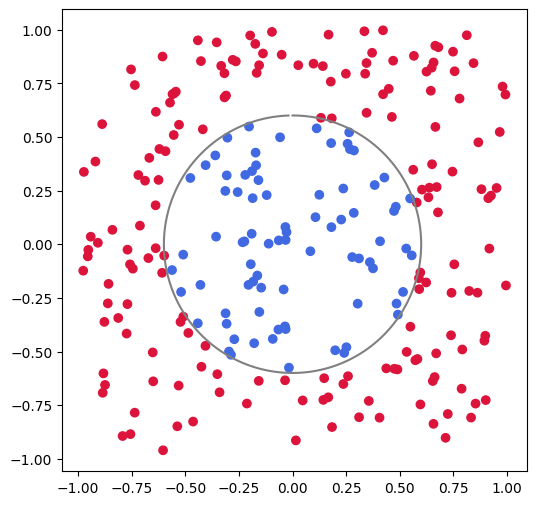

In [15]:
# Show Original Data and Circle Boundary
# Reduce this back from 3d to 2d and we will get a circle
plt.figure(figsize=(6,6))
plt.scatter(embedded_points[:, 0], embedded_points[:, 1], color=colors)

angels = np.linspace(0, 2 * np.pi, num=200, endpoint=False)
x = 0.6 * np.sin(angels)
y = 0.6 * np.cos(angels)
plt.plot(x, y, color="grey")

plt.xlabel("")
plt.ylabel("")

#Quantum Feature Map Example

Purpose: This cell shows how classical data can be encoded into a quantum state using a specific type of quantum circuit called a `ZZFeatureMap` from Qiskit.

What it does:

  * Imports the ZZFeatureMap tool from Qiskit.
  * Sets up a ZZFeatureMap circuit for a certain number of qubits (4 in this case).
  * Gets some random classical numbers to use as example data (matching the number of qubits).
  * Assigns these classical numbers to the parameters of the gates within the circuit.
  * Draws a picture of the resulting quantum circuit with the data encoded.

Uses: `qiskit.circuit.library`, `numpy`.

Input: Circuit settings (number of qubits, layers, entanglement type) and sample classical data.

Output: A quantum circuit object and a plot showing the circuit diagram.

Relevance to QML/SVM: This is a fundamental step in many Quantum Machine Learning algorithms, including Quantum SVMs. It shows how you take your classical data and prepare it in a quantum system.

/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


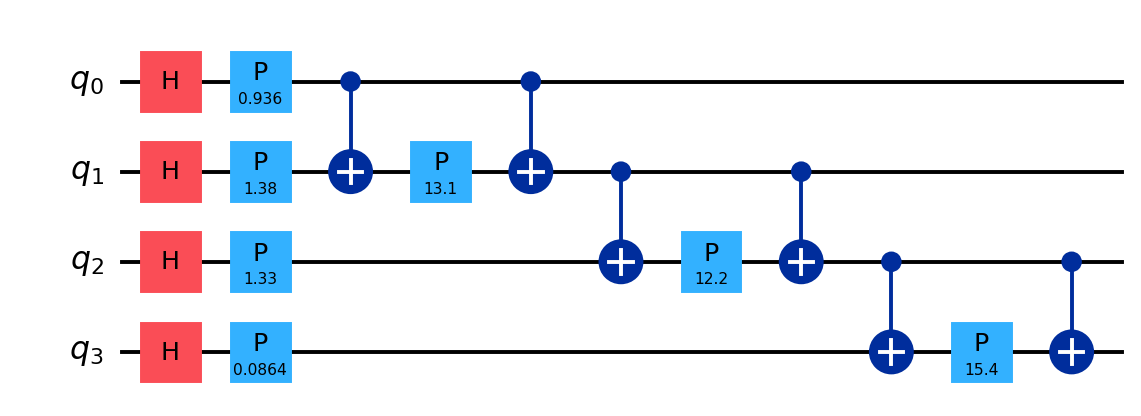

In [16]:
# Quantum Feature Map Example
from qiskit.circuit.library import ZZFeatureMap

num_qbits = 4
x = np.random.random(num_qbits)

data = ZZFeatureMap(feature_dimension=num_qbits, reps=1, entanglement="linear")
data.assign_parameters(x, inplace=True)
data.decompose().draw("mpl", style="iqx", scale=1.4)


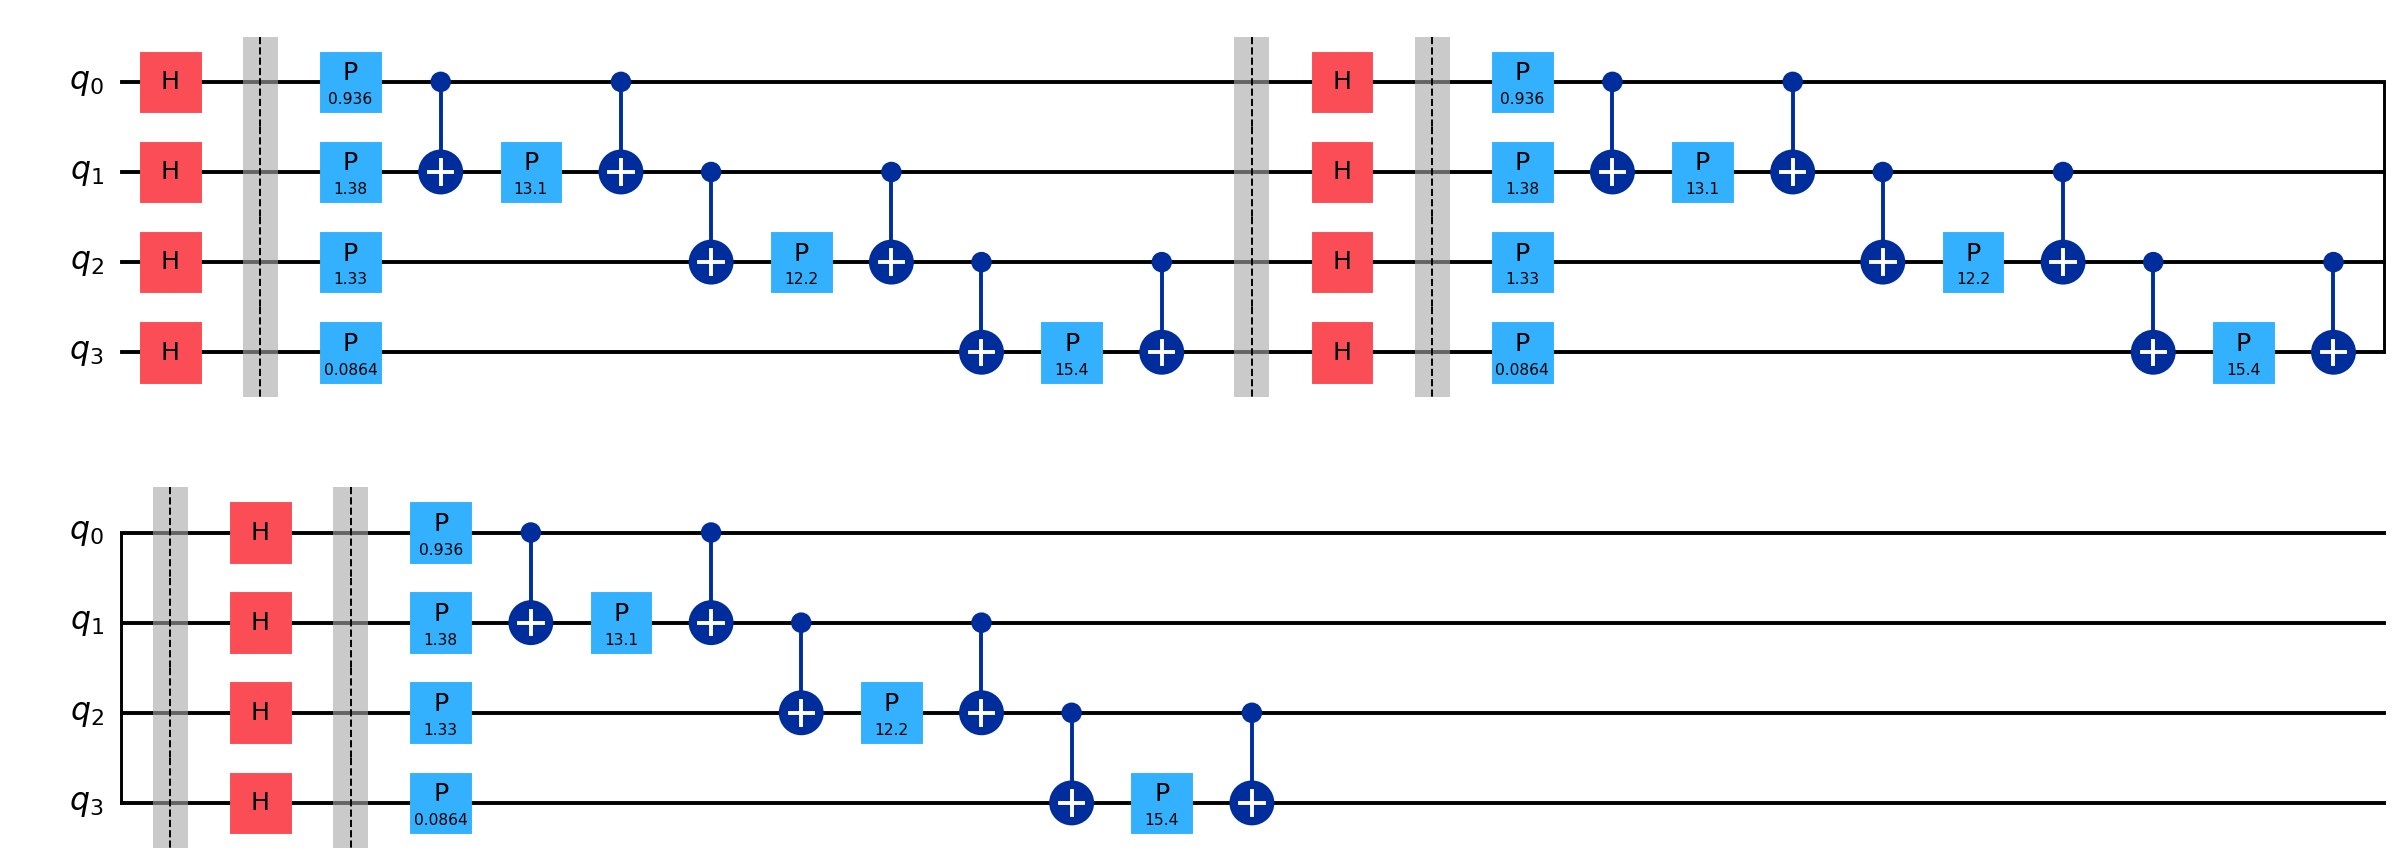

In [17]:
data = ZZFeatureMap(feature_dimension=num_qbits, reps=3, entanglement="linear", insert_barriers=True)
data.assign_parameters(x, inplace=True)
data.decompose().draw("mpl", style="iqx", scale=1.4)

# Quantum Kernel Evaluation

This code implements a quantum kernel using Qiskit's `ZZFeatureMap`. The kernel evaluates the similarity between two data points in a quantum feature space.

## How it works

1. Creates a quantum circuit using `ZZFeatureMap` with 2 dimensions
2. Encodes the first point (`x_i`) into the circuit
3. Applies the inverse feature map for the second point (`x_j`)
4. Measures the circuit multiple times (`shots=1024`)
5. Returns the probability of measuring all zeros

## Technical Details

- The `ZZFeatureMap` requires exactly 2 parameters (`dimension=2`)
- Single values are automatically converted to 2D vectors
- Uses `AerSimulator` for quantum circuit simulation
- Returns a value between 0 and 1 representing similarity

## Example Usage

```python
x = np.array([1.0, 2.0, 3.0, 4.0])
result = evaluate_kernel(x[2], x[3])  # Compares points 3.0 and 4.0
```

## Notes

- Higher return values indicate greater similarity between points
- The kernel is symmetric: `evaluate_kernel(x_i, x_j) == evaluate_kernel(x_j, x_i)`
- The result is probabilistic due to quantum measurement

In [18]:
# Building a quantum kernel
# Import necessary libraries from Qiskit and NumPy
from qiskit import transpile, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap
import numpy as np

# Set up the backend for simulation and define the number of shots
backend = AerSimulator()
shots = 1024

# Define the dimension of the feature vector and create a ZZFeatureMap
# The dimension determines the number of qubits needed.
dimension = 2
feature_map = ZZFeatureMap(dimension, reps=1)

# Define a function to evaluate the quantum kernel between two data points x_i and x_j
def evaluate_kernel(x_i, x_j):
    # Ensure that both inputs are NumPy arrays of dimension 2.
    # If a single value is provided, duplicate it to create a 2-element array.
    if not isinstance(x_i, (list, np.ndarray)):
        x_i = np.array([x_i, x_i])
    if not isinstance(x_j, (list, np.ndarray)):
        x_j = np.array([x_j, x_j])

    # Ensure we have exactly 2 elements in each array.
    # If more elements are provided, take the first one and duplicate it.
    if len(x_i) != 2:
        x_i = np.array([x_i[0], x_i[0]])
    if len(x_j) != 2:
        x_j = np.array([x_j[0], x_j[0]])

    # Create a new quantum circuit with the specified dimension (number of qubits)
    circuit = QuantumCircuit(dimension)
    # Apply the feature map encoding the first data point x_i
    circuit.compose(feature_map.assign_parameters(x_i), inplace=True)
    # Apply the inverse of the feature map encoding the second data point x_j
    # This is the core of the kernel calculation using the 'kernel trick'
    circuit.compose(feature_map.assign_parameters(x_j).inverse(), inplace=True)
    # Add measurements to all qubits
    circuit.measure_all()

    # Transpile the circuit for the specified backend
    transpiled = transpile(circuit, backend)
    # Run the transpiled circuit on the backend and get the measurement counts
    counts = backend.run(transpiled, shots=shots).result().get_counts()

    # Calculate the kernel value as the probability of measuring the |0...0> state
    # This probability is obtained by dividing the count of '0' * dimension state
    # by the total number of shots.
    return counts.get("0" * dimension, 0) / shots

In [19]:
evaluate_kernel(x[2], x[3])

0.3974609375

In [ ]:
# We can also use Qiskit-machine-learning directly (Not in Colab)
from qiskit_machine_learning.kernels import QuantumKernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
kernel.evaluate(x[2], x[3])

Text(0, 0.5, '')

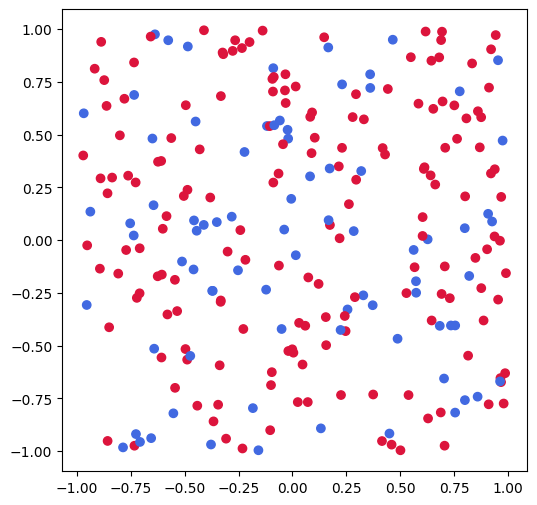

In [22]:
# Classification
points, labesls = circle()
colors = ["crimson" if label == 1 else "royalblue" for label in labels]

plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], color=colors)
plt.xlabel("")
plt.ylabel("")

In [ ]:
# We can also use results from Qiskit-machine-learning directly (Not in Colab)
qsvm = SVC(kernel=kernel.evaluate)
qsvm.fit(points, labels)
predicted = qsvm.predict(points)

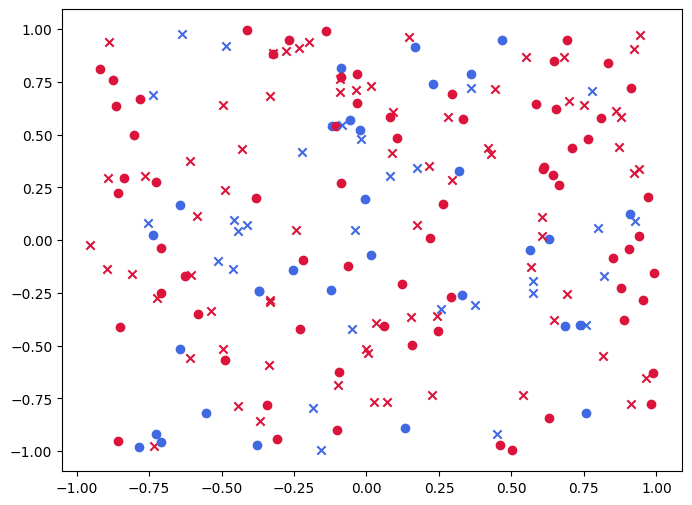

In [23]:
# We can also plot the results from Qiskit-machine-learning directly
markers = ["o" if label == predicted_label else "x" for label, predicted_label in zip(labels, predicted)]
plt.figure(figsize=(8,6))
for point, marker, color in zip(points.tolist(), markers, colors):
  plt.scatter(point[0], point[1], marker=marker, color=color)

# Variational Quantum classsifier

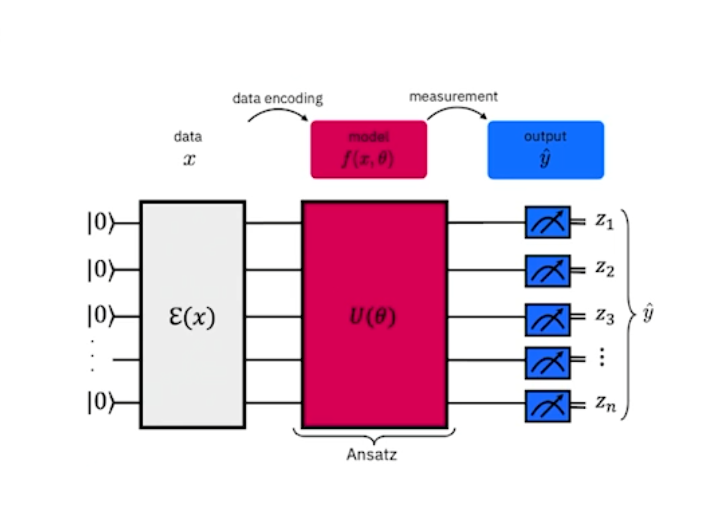

#Trainable Quantum Circuit (Ansatz)

Purpose: This cell sets up and shows a standard type of quantum circuit structure called an Ansatz (`EfficientSU2`) from Qiskit. This circuit is designed to be trainable, meaning its internal parameters can be adjusted during a learning process.

What it does:
  * Imports the EfficientSU2 tool from Qiskit.
  * Creates an EfficientSU2 circuit for 4 qubits with a specific structure (1 layer, pairwise entanglement). This circuit is a template with parameters that will be optimized later.
  * Draws a diagram of this circuit template.

Uses: `qiskit.circuit.library`.

Input: Circuit structure settings (number of qubits, layers, entanglement type).

Output: A quantum circuit object and a plot showing the circuit diagram.

Relevance to QML/SVM: In many Quantum Machine Learning models (like Variational Quantum Classifiers), an Ansatz is placed after the data encoding circuit. Its parameters are adjusted by a classical optimizer to perform the learning task (e.g., classification).

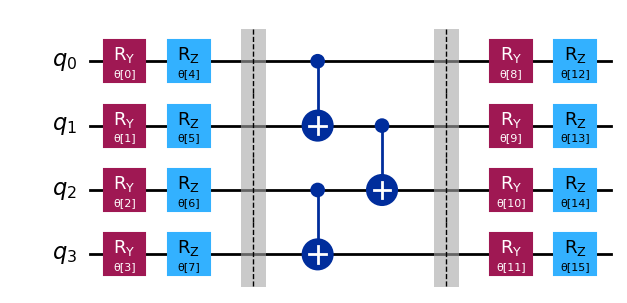

In [24]:
# Trainable Quantum Circuit (Ansatz)
from qiskit.circuit.library import EfficientSU2
ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="pairwise", insert_barriers=True)
ansatz.decompose().draw("mpl", style="iqx")

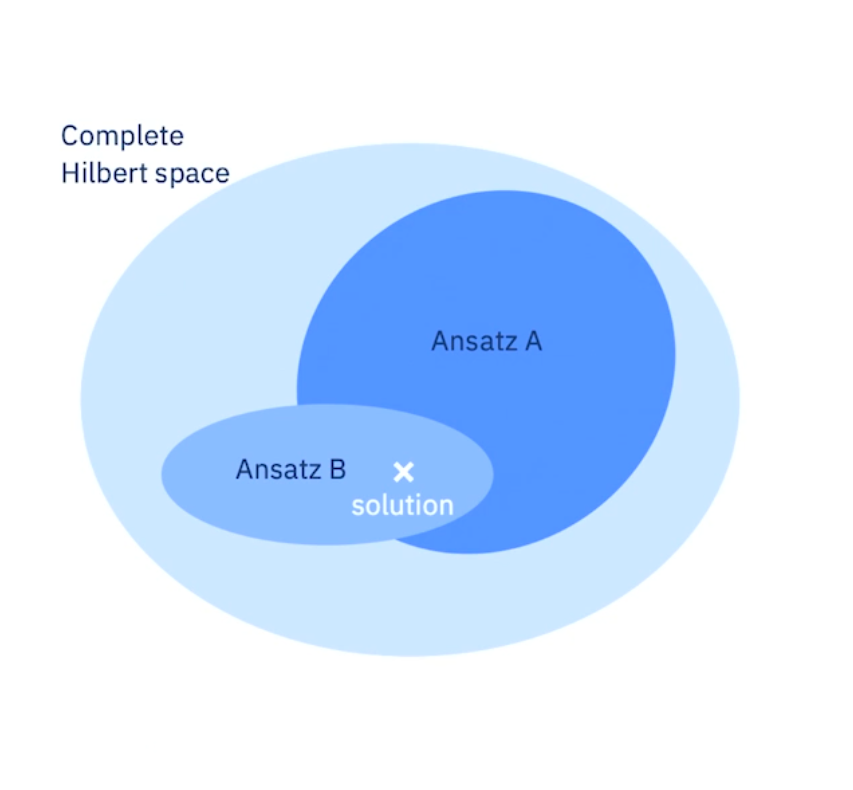

#Another Type of Trainable Circuit: RealAmplitudes

Purpose: This cell shows a different common structure for the trainable part (Ansatz) of a Quantum Machine Learning circuit, called `RealAmplitudes`. This is an alternative to the `EfficientSU2` shown in the previous cell, offering a different gate arrangement.

What it does:
  * Imports the `RealAmplitudes` tool from Qiskit.
  * Creates a `RealAmplitudes` circuit template for 4 qubits with a specific number of layers and entanglement style (same as the last example for comparison). This circuit has parameters that would be adjusted during training.
  * Draws the diagram of this circuit template.

Uses: `qiskit.circuit.library`.

Input: Circuit structure settings (number of qubits, layers, entanglement type).

Output: A quantum circuit object and a plot showing the circuit diagram.

Relevance to QML/SVM: QML models often combine a data encoding circuit (Feature Map) with a trainable circuit (Ansatz). This shows another standard Ansatz option (RealAmplitudes) that can be used as the learning part, with a structure different from EfficientSU2.

/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


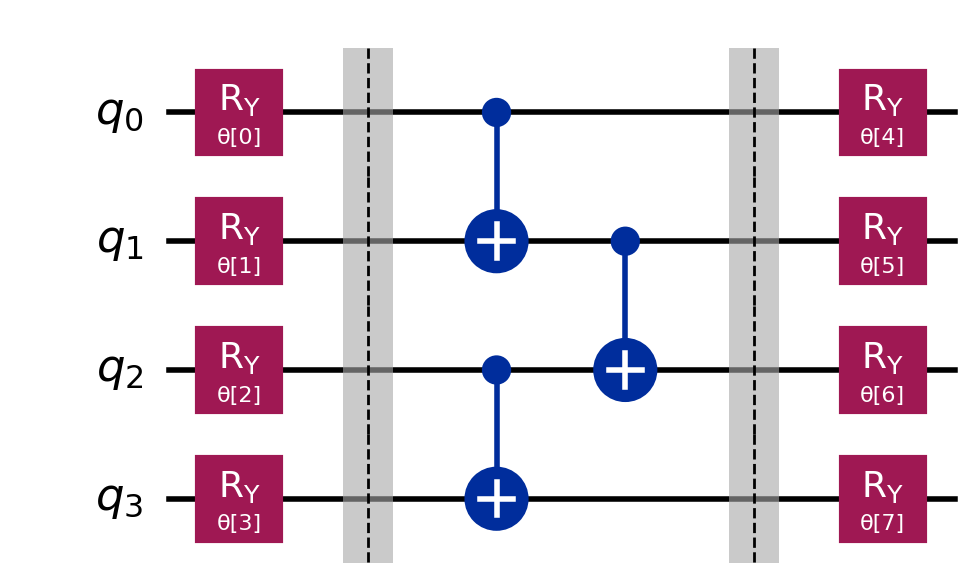

In [25]:
# Heuristic vs. more problem-specific Ansatz
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=4, reps=1, entanglement="pairwise", insert_barriers=True)
ansatz.decompose().draw("mpl", style="iqx", scale=2)

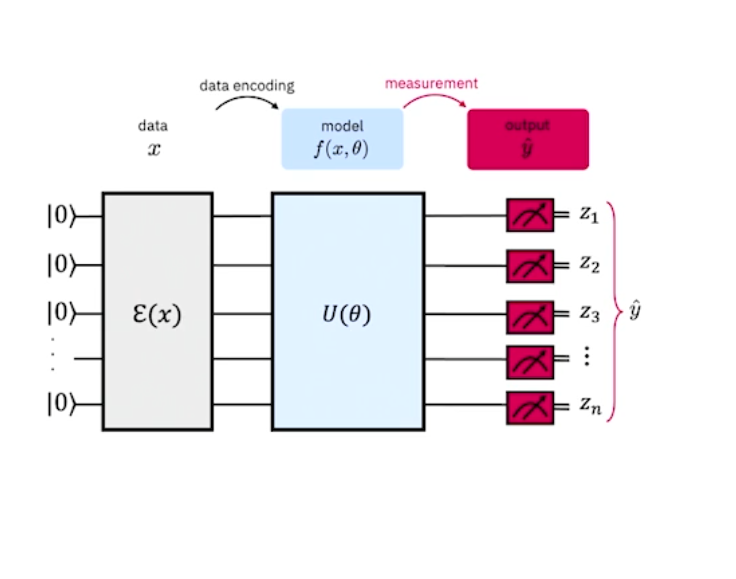

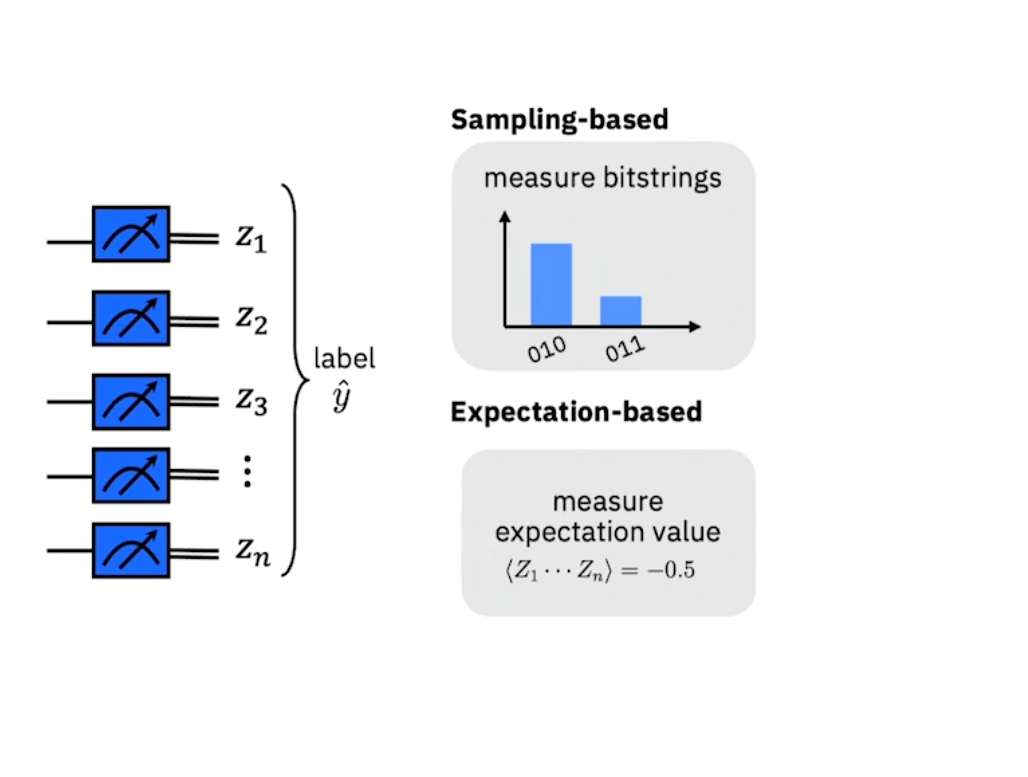

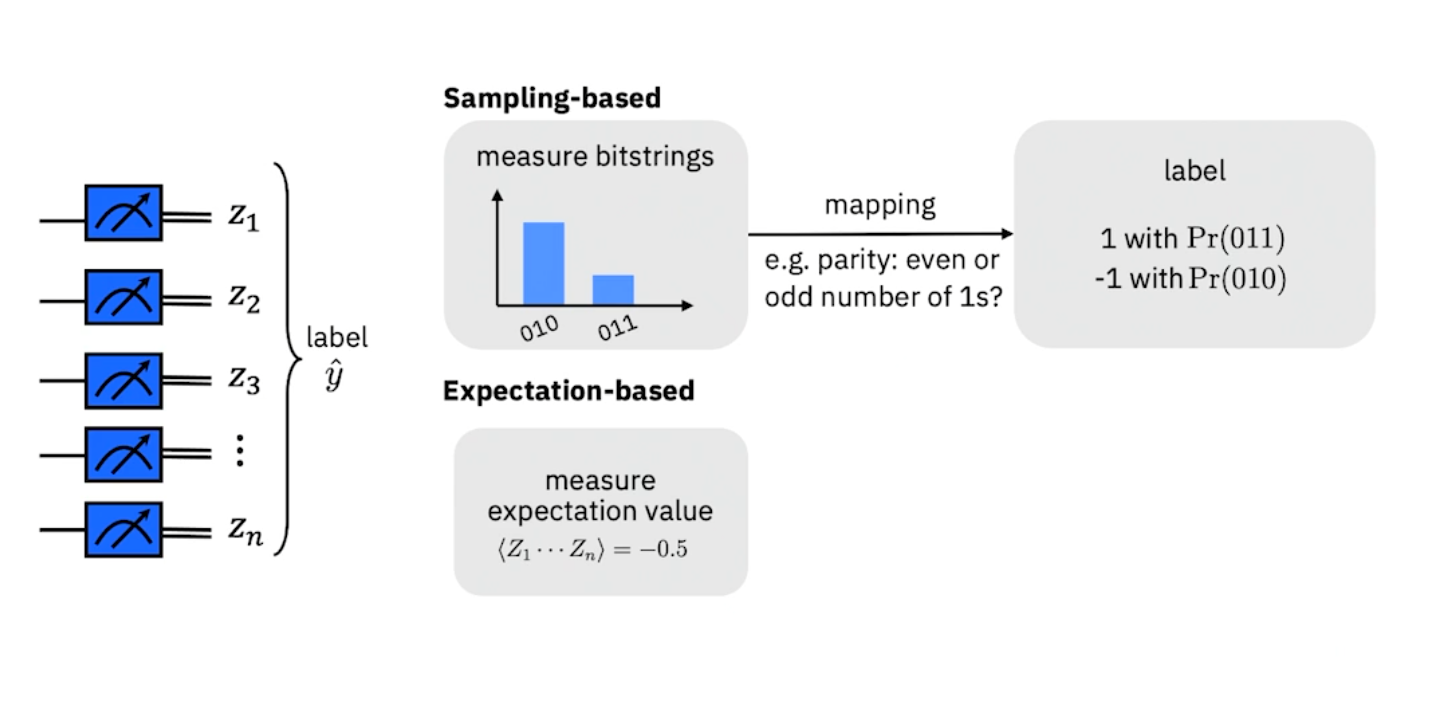

#Full QML Circuit Ready to Run

Purpose: This cell builds the complete quantum circuit used in a Quantum Machine Learning model by combining the data encoding part (Feature Map) and the trainable part (Ansatz). It then assigns specific example values to all the parameters in the circuit (both for the data and for the trainable gates) and shows the final circuit diagram.

What it does:
  * Combines a `ZFeatureMap` (to encode 1 classical data number) and a `RealAmplitudes` Ansatz (the trainable circuit, for 1 qubit) into a single quantum circuit.
  * Takes a sample classical data value (the number 1).
  * Takes some sample values for the trainable parameters in the Ansatz.
  * Binds (assigns) these specific numbers to all the placeholder parameters throughout the combined circuit.
  * Draws the diagram of this final circuit. All the gates in this drawn circuit now have specific, fixed rotation angles determined by the sample data and sample parameters.

Uses: `qiskit.circuit.library`, `numpy`.

Input: The feature map and ansatz circuit definitions, sample classical data, and sample trainable parameter values.

Output: A Qiskit quantum circuit object with all parameters set, and a plot showing the diagram of this circuit.

Relevance to QML/SVM: This shows the completed quantum circuit that would be executed on a quantum computer or simulator to perform a computation based on both the input data and the learned parameters of the QML model.

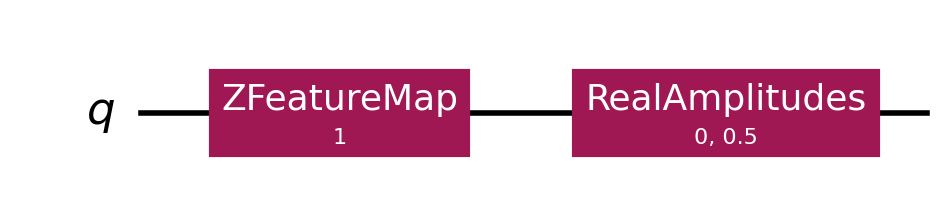

In [26]:
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
import numpy as np

num_features = 1

feature_map = ZFeatureMap(num_features)
model = RealAmplitudes(num_features, reps=1, entanglement="pairwise")

circuit = feature_map.compose(model)

data = np.array([1])
angels = np.arange(model.num_parameters) / model.num_parameters

bound = circuit.assign_parameters(np.concatenate((data, angels)))

bound.draw("mpl", style="iqx", scale=2)

#Prepare Circuit for Running (Updated Simulator)

Purpose: This cell takes the final quantum circuit and prepares it to be run on a quantum simulator, using Qiskit's modern simulator interface (`qiskit-aer`).

What it does:
  * Adds measurement gates to the circuit so you can get classical results (0s and 1s) from the qubits.
  * Selects the target simulator backend using AerSimulator from qiskit_aer (this is the updated way to access Qiskit's main simulators).
  * Transpiles the circuit: This optimizes the circuit and translates its gates so it can run efficiently and correctly on the chosen simulator.
  * Draws the diagram of the circuit after it has been optimized.

Uses: `qiskit_aer, qiskit`. This code assumes you have a circuit variable named `bound` from a previous step.

Input: The `bound` quantum circuit.

Output: The optimized `transpiled` circuit object and a plot showing its diagram.

Relevance to QML/SVM: These are the necessary steps to get your quantum circuit ready to actually execute on a simulator or hardware to get the results needed for your QML task (like calculating a loss or making a prediction).

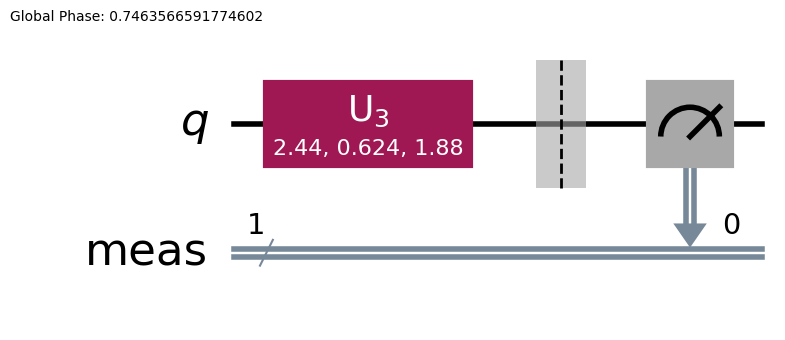

In [27]:
# Now we can measure this single qbit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap

bound.measure_all()
backend = AerSimulator()

transpiled = transpile(bound, backend)

transpiled.draw("mpl", style="iqx", scale=2)

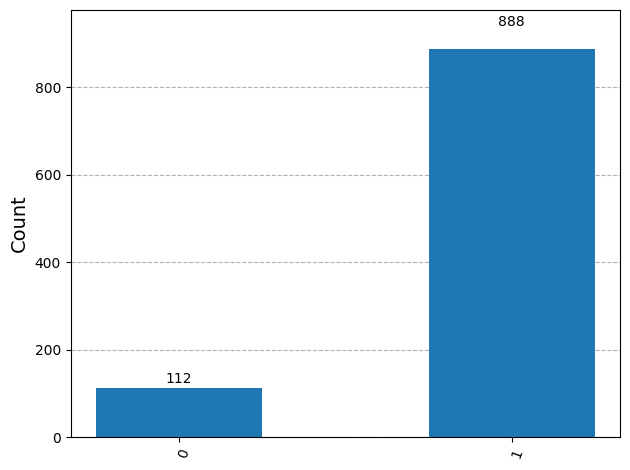

In [29]:
# Plot the distribution
from qiskit.visualization import plot_histogram

result = backend.run(transpiled, shots=1000).result()
counts = result.get_counts()

plot_histogram(counts)

In [31]:
# define the parity function
def parity(bistring):
  # return 1 if there's an even number of 1's, otherwise return -1
  return 1 if bistring.count("1") % 2 else -1

labels = {parity(bistring): count / 1000 for bistring, count in counts.items()}
print(labels)

{-1: 0.112, 1: 0.888}


This picture illustrates two approaches for assigning a label (`y^`​) based on quantum measurements:

  Sampling-based: Measure the quantum state to obtain classical bitstrings

1.   Sampling-based: Measure the quantum state to obtain classical bitstrings (`z1​,...,zn`​). A probability distribution of these bitstrings is observed (shown as a bar plot). A mapping is then applied to the bitstrings (e.g., checking for even or odd parity) to determine the label with a certain probability.
2.   Expectation-based: Measure the expectation value of an observable related to the bitstrings (`⟨Z1​...Zn​⟩`). This expectation value is a single numerical value. A mapping is applied to this expectation value (e.g., taking the sign) to determine the label with a probability derived from the expectation value.


Both methods show how quantum measurement results can be translated into a classical label, relevant in fields like quantum machine learning.

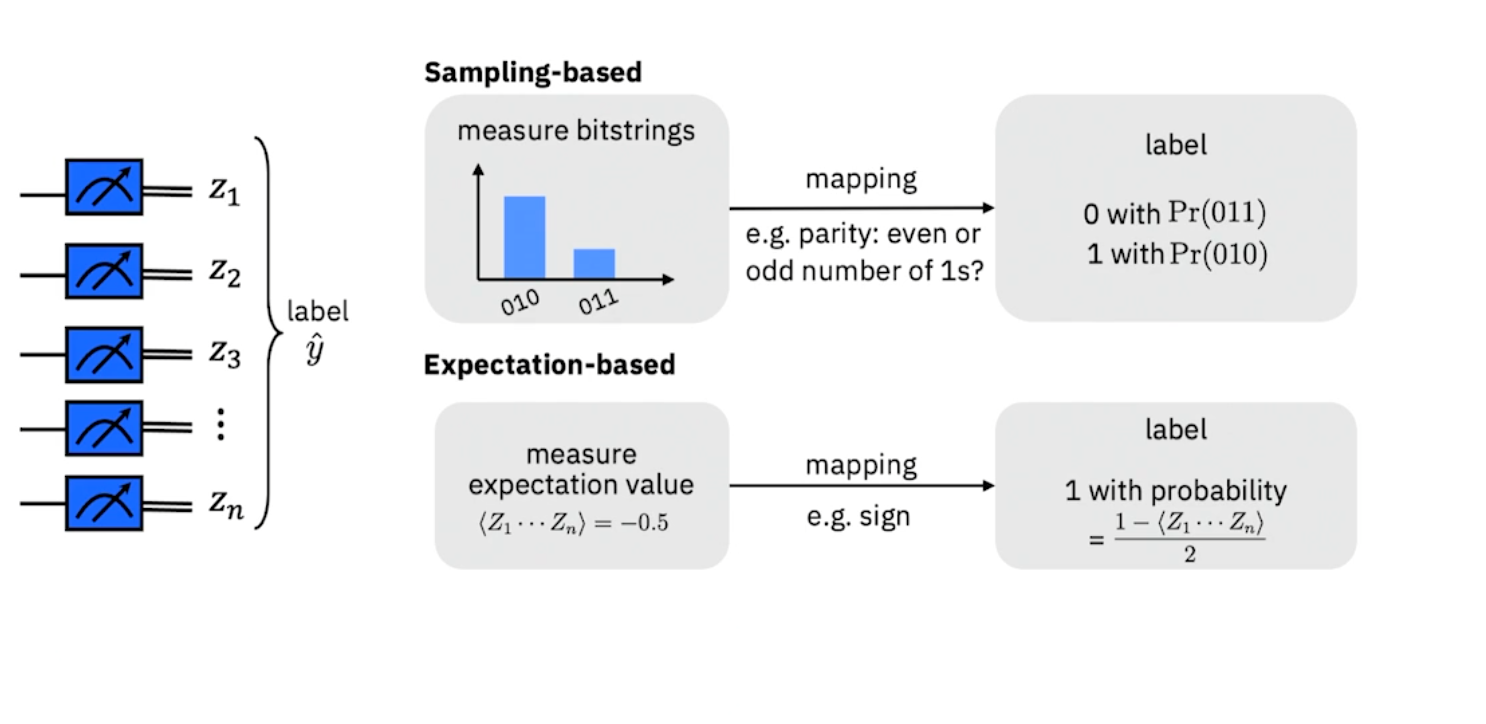

In [ ]:
# Example of Expectation-based (Not in Colab)
probability_for_1 = (1 - expectation_value) / 2

expectation_labels = {1: probability_for_1, -1: 1 - probability_for_1}
print(expectation_labels)